# PySpark

## Init Engine

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('pyspark-covid').getOrCreate()
#set timestamp
spark.sql("set spark.sql.session.timeZone=UTC")

DataFrame[key: string, value: string]

# Data loading

## Create DataFrame from CSV file

In [2]:
df = spark.read. \
    option("header", "true"). \
    option("inferSchema", "true"). \
    option("delimiter", ","). \
    option("escape", "\""). \
    csv("/data/time_series_covid19_deaths_global_narrow.csv")
    
df.printSchema()

root
 |-- Province/State: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long: double (nullable = true)
 |-- Date: string (nullable = true)
 |-- Value: integer (nullable = true)
 |-- ISO 3166-1 Alpha 3-Codes: string (nullable = true)
 |-- Region Code: integer (nullable = true)
 |-- Sub-region Code: integer (nullable = true)
 |-- Intermediate Region Code: integer (nullable = true)



## Normalize schema

* Remove schema name from special char

In [3]:
normDf = df. \
    withColumnRenamed("ISO 3166-1 Alpha 3-Codes", "iso_country_code"). \
    withColumnRenamed("Region Code", "region_code"). \
    withColumnRenamed("Sub-region Code", "sub_region_code"). \
    withColumnRenamed("Intermediate Region Code", "interm_region_code"). \
    withColumnRenamed("Province/State", "province_state"). \
    withColumnRenamed("Country/Region", "country_region")

normDf.printSchema()

root
 |-- province_state: string (nullable = true)
 |-- country_region: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long: double (nullable = true)
 |-- Date: string (nullable = true)
 |-- Value: integer (nullable = true)
 |-- iso_country_code: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- sub_region_code: integer (nullable = true)
 |-- interm_region_code: integer (nullable = true)



# Data cleaning

## Sampling

In [4]:
normDf.show(1, truncate=False)

+--------------+--------------+--------+---------+----------+-----+----------------+-----------+---------------+------------------+
|province_state|country_region|Lat     |Long     |Date      |Value|iso_country_code|region_code|sub_region_code|interm_region_code|
+--------------+--------------+--------+---------+----------+-----+----------------+-----------+---------------+------------------+
|null          |Afghanistan   |33.93911|67.709953|2020-10-01|1458 |AFG             |142        |34             |null              |
+--------------+--------------+--------+---------+----------+-----+----------------+-----------+---------------+------------------+
only showing top 1 row



## Convert data type or value

In [5]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

#### Date & Timestamp

In [6]:
normDf = normDf. \
    withColumn("Date", col("Date").cast(TimestampType()))

normDf.printSchema()

root
 |-- province_state: string (nullable = true)
 |-- country_region: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long: double (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Value: integer (nullable = true)
 |-- iso_country_code: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- sub_region_code: integer (nullable = true)
 |-- interm_region_code: integer (nullable = true)



##### Test date parsing

In [3]:
from pyspark.sql.functions import *

date_df = spark.createDataFrame([(1,'May 15th 2021, 12:34:56.789')], ['id','@timestamp'])

# https://docs.oracle.com/javase/8/docs/api/java/text/SimpleDateFormat.html
date_df.select(
    '@timestamp', 
    from_unixtime(unix_timestamp('@timestamp', "MMM dd'th' yyyy, HH:mm:ss.SSS")).alias('date')
).show(2,False)

+---------------------------+-------------------+
|@timestamp                 |date               |
+---------------------------+-------------------+
|May 15th 2021, 12:34:56.789|2021-05-15 12:34:56|
+---------------------------+-------------------+



#### UDF - Custom transformation

In [7]:
def convert(str, debug=False):
    if (debug):
        print("convert value :", str)
    if str is None:
        return None
    return str.lower() 

convertUDF = udf(lambda str: convert(str), StringType())

print(convert("AFG", True))

convert value : AFG
afg


In [8]:
normDf. \
    withColumn("iso_country_code", convertUDF(col("iso_country_code"))). \
    show(1, truncate=False)

+--------------+--------------+--------+---------+----------+-----+----------------+-----------+---------------+------------------+
|province_state|country_region|Lat     |Long     |Date      |Value|iso_country_code|region_code|sub_region_code|interm_region_code|
+--------------+--------------+--------+---------+----------+-----+----------------+-----------+---------------+------------------+
|null          |Afghanistan   |33.93911|67.709953|2020-10-01|1458 |afg             |142        |34             |null              |
+--------------+--------------+--------+---------+----------+-----+----------------+-----------+---------------+------------------+
only showing top 1 row



In [21]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import re

def convert(str, debug=False):
    if (debug):
        print("convert value :", str)
    if str is None:
        return None
    result = dict()
    result['k1'], result['k2'], result['k3'] = re.findall(r'Logger text: (\w+), (\w+) - (\w+)', str)[0]
    return result

convertUDF = udf(convert, MapType(StringType(), StringType()))

print(convert('Logger text: PARAM1, PARAM2 - PARAM3', True))

convert value : Logger text: PARAM1, PARAM2 - PARAM3
{'k1': 'PARAM1', 'k2': 'PARAM2', 'k3': 'PARAM3'}


In [22]:
logList = ["Logger text: V1, V2 - V3", "Logger text: W1, W2 - W3"]
logDF = spark.createDataFrame(logList, StringType())


convertDF = logDF.select(convertUDF("value").alias("log"))
convertDF.select(col("log.k1"), col("log.k2"), col("log.k3")).show(truncate=False)

+---+---+---+
|k1 |k2 |k3 |
+---+---+---+
|V1 |V2 |V3 |
|W1 |W2 |W3 |
+---+---+---+



In [9]:
from datetime import datetime, timedelta
from pyspark.sql.functions import *
from pyspark.sql.types import *

def convertTimestamp(str, debug=False):
    if (debug):
        print("convert Timestamp value :", str)
    if str is None:
        return None
    # https://docs.python.org/3/library/datetime.html#datetime.datetime.strptime
    return (datetime.strptime(str,'%Y-%b-%d %H:%M') - timedelta(hours=8))

convertTimestampUDF = udf(lambda str: convertTimestamp(str), TimestampType())

print(convertTimestamp('2021-Jan-15 12:34', True))

convert Timestamp value : 2021-Jan-15 12:34
2021-01-15 04:34:00


## DataSet Validation
### Check overall values

In [9]:
from pyspark.sql.functions import sum, col, desc

column = "sum_casualties"

isoDF = normDf. \
    groupBy(col("iso_country_code")). \
    agg(sum("Value").alias(column)). \
    orderBy(desc(column))

isoDF.agg(sum(column)). \
    show(truncate=False)

+-------------------+
|sum(sum_casualties)|
+-------------------+
|98961992           |
+-------------------+



### Column analysis

#### Numeric values

In [10]:
from pyspark.sql.functions import count, mean, stddev, min, max, sum

normDf.agg(count("Lat"), mean("Lat"), stddev("Lat"), min("Lat"), max("Lat"), sum("Lat")).show()

+----------+-----------------+-----------------+--------+--------+------------------+
|count(Lat)|         avg(Lat)| stddev_samp(Lat)|min(Lat)|max(Lat)|          sum(Lat)|
+----------+-----------------+-----------------+--------+--------+------------------+
|     67564|21.07662424812158|24.85792699104551|-51.7963| 71.7069|1424021.0407000864|
+----------+-----------------+-----------------+--------+--------+------------------+



#### String values

In [11]:
from pyspark.sql.functions import col

distinctValuesDF = normDf. \
    select(col("iso_country_code"), col("country_region"), col("province_state"), col("Lat"), col("Long")). \
    distinct()

print(distinctValuesDF.count())

266


In [12]:
from pyspark.sql.functions import desc

distinctValuesDF.groupBy("iso_country_code").count().orderBy(desc("count")).show()

+----------------+-----+
|iso_country_code|count|
+----------------+-----+
|             CHN|   31|
|             CAN|   12|
|             AUS|    8|
|            null|    5|
|             SPM|    1|
|             ABW|    1|
|             BRB|    1|
|             COD|    1|
|             LVA|    1|
|             HTI|    1|
|             PSE|    1|
|             BRA|    1|
|             ARM|    1|
|             JOR|    1|
|             CUB|    1|
|             MOZ|    1|
|             SOM|    1|
|             FRA|    1|
|             BRN|    1|
|             TCA|    1|
+----------------+-----+
only showing top 20 rows



In [13]:
distinctValuesDF.where("iso_country_code is null").show()

+----------------+----------------+----------------+-------+-------+
|iso_country_code|  country_region|  province_state|    Lat|   Long|
+----------------+----------------+----------------+-------+-------+
|            null|          Canada|  Grand Princess|    0.0|    0.0|
|            null|      MS Zaandam|            null|    0.0|    0.0|
|            null|          Canada|Diamond Princess|    0.0|    0.0|
|            null|  United Kingdom| Channel Islands|49.3723|-2.3644|
|            null|Diamond Princess|            null|    0.0|    0.0|
+----------------+----------------+----------------+-------+-------+



In [14]:
from pyspark.sql.functions import col

distinctValuesDF.where(col("iso_country_code") == "CHN").show()

+----------------+--------------+--------------+------------------+------------------+
|iso_country_code|country_region|province_state|               Lat|              Long|
+----------------+--------------+--------------+------------------+------------------+
|             CHN|         China|       Qinghai|           35.7452|           95.9956|
|             CHN|         China|       Ningxia|           37.2692|          106.1655|
|             CHN|         China|      Xinjiang|           41.1129|           85.2401|
|             CHN|         China|      Shandong|           36.3427|          118.1498|
|             CHN|         China|       Guangxi|           23.8298|          108.7881|
|             CHN|         China|         Gansu|           35.7518|          104.2861|
|             CHN|         China|       Jiangsu|           32.9711|           119.455|
|             CHN|         China|         Henan|           37.8957|          114.9042|
|             CHN|         China|         T

#### Date values

In [15]:
from pyspark.sql.functions import min, max

column = "Date"
normDf.agg(min(column).alias("start_date_range"), max(column).alias("end_date_range")).show(truncate=False)

+----------------+--------------+
|start_date_range|end_date_range|
+----------------+--------------+
|2020-01-22      |2020-10-01    |
+----------------+--------------+



## Understand distribution
### Parent child columns

In [16]:
distinctValuesDF.groupBy(col("iso_country_code")).count().show()

+----------------+-----+
|iso_country_code|count|
+----------------+-----+
|             HTI|    1|
|             PSE|    1|
|             BRB|    1|
|             POL|    1|
|             LVA|    1|
|             ZMB|    1|
|             JAM|    1|
|             SPM|    1|
|             BRA|    1|
|             ARM|    1|
|             MOZ|    1|
|             JOR|    1|
|             CUB|    1|
|             SOM|    1|
|             FRA|    1|
|             ABW|    1|
|             TCA|    1|
|             COD|    1|
|             BRN|    1|
|             BOL|    1|
+----------------+-----+
only showing top 20 rows



In [17]:
distinctValuesDF.groupBy(col("iso_country_code")). \
    count(). \
    orderBy(desc("count")). \
    show()

+----------------+-----+
|iso_country_code|count|
+----------------+-----+
|             CHN|   31|
|             CAN|   12|
|             AUS|    8|
|            null|    5|
|             SPM|    1|
|             ABW|    1|
|             LVA|    1|
|             COD|    1|
|             PSE|    1|
|             ZMB|    1|
|             JAM|    1|
|             BRA|    1|
|             ARM|    1|
|             MOZ|    1|
|             JOR|    1|
|             CUB|    1|
|             SOM|    1|
|             FRA|    1|
|             BRN|    1|
|             TCA|    1|
+----------------+-----+
only showing top 20 rows



In [7]:
from pyspark.sql.functions import col, count, collect_set

regionDf = normDf.where("province_state IS NOT NULL"). \
    groupBy("iso_country_code", "country_region", "province_state"). \
        agg(avg("Value").alias("avg_val")).\
    groupBy("iso_country_code", "country_region"). \
        agg( \
            count("province_state").alias("count"), \
            # Collect all values
            collect_list("avg_val").alias("value_list"), \
            # Collect all distinct values
            collect_set("province_state").alias("contained_province") \
        ). \
    where(col("count") > 1). \
    where("iso_country_code IS NOT NULL"). \
    orderBy(desc("count"))

regionDf. \
    show(truncate=False)

+----------------+--------------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|iso_country_code|country_region|count|value_list                                                                                                                

### Distribution By Time Window

In [19]:
from pyspark.sql.functions import col, sum, desc, window

tsDF = normDf. \
    groupBy(col("iso_country_code"), col("country_region"), col("province_state"), window(col("Date"), "1 day")). \
    agg(sum("Value").alias("casualties")). \
    orderBy(desc("window.start"))

tsDF. \
    show(truncate=False)

+----------------+----------------------+--------------------------------+------------------------------------------+----------+
|iso_country_code|country_region        |province_state                  |window                                    |casualties|
+----------------+----------------------+--------------------------------+------------------------------------------+----------+
|SGP             |Singapore             |null                            |[2020-10-01 00:00:00, 2020-10-02 00:00:00]|27        |
|ITA             |Italy                 |null                            |[2020-10-01 00:00:00, 2020-10-02 00:00:00]|35918     |
|MYS             |Malaysia              |null                            |[2020-10-01 00:00:00, 2020-10-02 00:00:00]|136       |
|MMR             |Burma                 |null                            |[2020-10-01 00:00:00, 2020-10-02 00:00:00]|321       |
|CZE             |Czechia               |null                            |[2020-10-01 00:00:00, 2

#### Window value stats

In [20]:
column = "window.start"
tsDF.agg(min(column).alias("start_date_range"), max(column).alias("end_date_range")).show(truncate=False)

+-------------------+-------------------+
|start_date_range   |end_date_range     |
+-------------------+-------------------+
|2020-01-22 00:00:00|2020-10-01 00:00:00|
+-------------------+-------------------+



### Data preparation & ordering

In [21]:
storedDF = tsDF.select("iso_country_code", "country_region", "province_state", "window.start", "window.end", "casualties"). \
    na.fill("unknown", subset=["country_region", "province_state"]). \
    orderBy("iso_country_code", "start")

storedDF.show(1, truncate=False)

+----------------+--------------+--------------+-------------------+-------------------+----------+
|iso_country_code|country_region|province_state|start              |end                |casualties|
+----------------+--------------+--------------+-------------------+-------------------+----------+
|null            |Canada        |Grand Princess|2020-01-22 00:00:00|2020-01-23 00:00:00|0         |
+----------------+--------------+--------------+-------------------+-------------------+----------+
only showing top 1 row



## Exporting

### Persist to CSV file

In [22]:
storedDF.coalesce(1). \
    write.mode('overwrite'). \
    option("mapreduce.fileoutputcommitter.marksuccessfuljobs","false"). \
    option("header","true"). \
    csv("/data/covid-19-by-country.csv")

### Save data into Table

In [23]:
storedDF. \
    write.mode("overwrite"). \
    saveAsTable("data")

### Export dataframe using .toPandas()

In [8]:
pandaDf = regionDf.select("count", "country_region", "contained_province", "value_list").toPandas()

In [9]:
pandaDf.head()

,count,country_region,contained_province,value_list
0,31,China,"[Inner Mongolia, Jilin, Fujian, Yunnan, Heilon...","[0.8385826771653543, 0.0, 1.484251968503937, 2..."
1,12,Canada,"[Northwest Territories, Newfoundland and Labra...","[2.1141732283464565, 0.003937007874015748, 116..."
2,8,Australia,"[Queensland, New South Wales, Northern Territo...","[4.291338582677166, 141.49606299212599, 33.322..."


# Tables

In [26]:
spark.sql("SHOW DATABASES").show()

+---------+
|namespace|
+---------+
|  default|
+---------+



In [27]:
spark.catalog.listTables("default")

[Table(name='data', database='default', description=None, tableType='MANAGED', isTemporary=False)]

### SparkSQL - Data query

In [ ]:
pdf = spark.sql("SELECT start as time, iso_country_code, casualties \
FROM data \
WHERE iso_country_code = 'FRA' \
ORDER BY time").toPandas()

pdf

# Visualization

## matplotlib

In [ ]:
import sys  
!{sys.executable} -m pip install --user matplotlib

### Single plot

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.plot(pdf['time'], pdf['casualties'], color='red')
plt.gcf().autofmt_xdate()
plt.show()

### Multiline plot

In [ ]:
fig, ax = plt.subplots()
for country in pdf['iso_country_code']:
    dataframe = pdf.loc[pdf['iso_country_code'] == country]
    ax.plot(dataframe['time'], dataframe['casualties'], label=country)

ax.set_title('Casualties per country')
ax.legend(loc='upper right')

### Box plot

In [10]:
import pandas as pd

data = pd.DataFrame()
for key in pandaDf['country_region']:
    dataframe = pandaDf.loc[pandaDf['country_region'] == key]
    values = pd.Series(dataframe['value_list'].tolist()[0])
    print(values.shape)
    data.insert(loc=0, column=key, value=values)
    
data

(31,)
(12,)
(8,)


,Australia,Canada,China
0,4.291339,2.114173,0.838583
1,141.496063,0.003937,0.000000
2,33.322835,116.964567,1.484252
3,8.606299,1634.188976,2.472441
4,6.295276,3203.196850,0.000000
5,2.114173,38.019685,5.688976
6,0.000000,120.125984,2.775591
7,2.771654,0.909449,5.547244
8,NaN,10.248031,20.000000
9,NaN,6.389764,3.645669


Colunm Name :  Australia
Column Contents :  <class 'pandas.core.series.Series'>
Colunm Name :  Canada
Column Contents :  <class 'pandas.core.series.Series'>
Colunm Name :  China
Column Contents :  <class 'pandas.core.series.Series'>


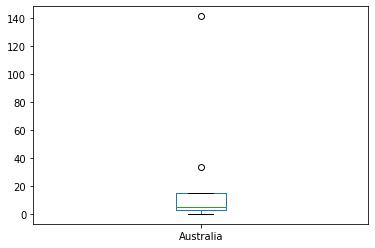

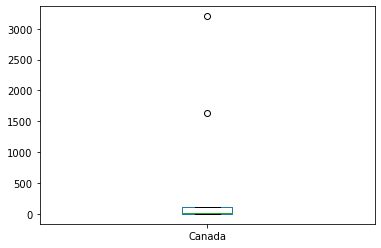

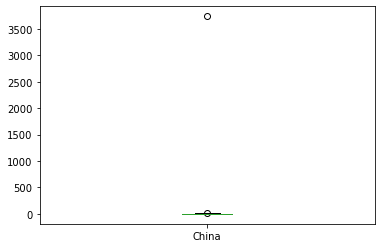

In [12]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
for (columnName, columnData) in data.iteritems(): 
    plt.figure()
    print('Colunm Name : ', columnName) 
    print('Column Contents : ', type(columnData))
    columnData.plot(kind='box')


## seaborn

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns   

sns.catplot(x ='time', y ='casualties', data = pdf)
plt.title('COVID-19 Casualities')
plt.show() 